In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#%% Prepare dataset

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Model / data parameters
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1::]

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   9248        max_pooling2d[0][0]              
_____________________________________________________________________________________________

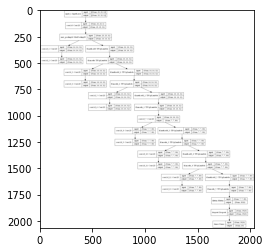

In [3]:
#%% Create model

inputs = tf.keras.Input(shape=input_shape)

def ResidualModule(inputs, filters):
    conv_1 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_2 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='linear')(conv_1)
    temp = tf.add(inputs, conv_2)
    outputs = tf.nn.relu(temp)
    
    return outputs


# Initial layers
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Residual 1
x = ResidualModule(x, 32)
x = ResidualModule(x, 32)
x = ResidualModule(x, 32)

# Residual 2
x = tf.keras.layers.Conv2D(80, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
x = ResidualModule(x, 80)
x = ResidualModule(x, 80)
x = ResidualModule(x, 80)

# Output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="resnet")

dot_img_file = 'resnetmini.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
plt.figure()
plt.imshow(plt.imread(dot_img_file))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())


In [4]:
#%% Train model

batch_size = 256
epochs = 50

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[earlystop],
                    use_multiprocessing=True,
                    validation_data=(x_test, y_test))

Epoch 1/50
235/235 [==============================] - 13s 36ms/step - loss: 1.0473 - accuracy: 0.8375 - val_loss: 0.0880 - val_accuracy: 0.9703
Epoch 2/50
235/235 [==============================] - 7s 32ms/step - loss: 0.1058 - accuracy: 0.9672 - val_loss: 0.0451 - val_accuracy: 0.9847
Epoch 3/50
235/235 [==============================] - 8s 32ms/step - loss: 0.0647 - accuracy: 0.9800 - val_loss: 0.0440 - val_accuracy: 0.9856
Epoch 4/50
235/235 [==============================] - 7s 32ms/step - loss: 0.0518 - accuracy: 0.9841 - val_loss: 0.0392 - val_accuracy: 0.9866
Epoch 5/50
235/235 [==============================] - 7s 32ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.0297 - val_accuracy: 0.9901
Epoch 6/50
235/235 [==============================] - 8s 32ms/step - loss: 0.0348 - accuracy: 0.9889 - val_loss: 0.0264 - val_accuracy: 0.9918
Epoch 7/50
235/235 [==============================] - 7s 32ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0278 - val_accuracy: 0.991

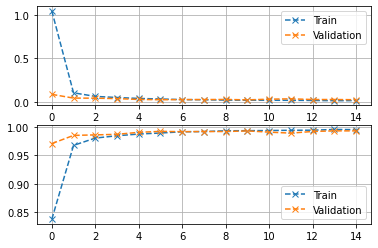

In [5]:
#%% Model visualization
plt.figure()
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(history.history['loss'], '--x')
plt.plot(history.history['val_loss'], '--x')
plt.legend(['Train', 'Validation'])
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(history.history['accuracy'], '--x')
plt.plot(history.history['val_accuracy'], '--x')
plt.legend(['Train', 'Validation'])

In [6]:
#%% Model evaluation
result = model.evaluate(x_test, y_test)
print("Test accuracy: {:.2f}%".format(result[1]*100))

313/313 [==============================] - 2s 5ms/step - loss: 0.0249 - accuracy: 0.9926
Test accuracy: 99.26%
